In [1]:
!pip install --upgrade pip
!pip install music21
!pip install matplotlib -qq
import os
import shutil
import copy
import tensorflow as tf
import numpy as np
import glob
import datetime
import pathlib
import pandas as pd
import collections
import music21
from music21 import *
from fractions import Fraction
import math
from matplotlib import pyplot as plt

#is the reason to explicitely set this just so that tensorflow and numpy produce the same randoms?
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
experiment_name = 'CEO_LSTM_TIM_DEMO_V1'

In [3]:
training_midi_path = './training_midi'

In [4]:
preprocessed_midi_path = './preprocessed_midi'

In [5]:
inference_midi_path = './inference_midi'

In [6]:
export_midi_path = './generated_midi/' + experiment_name

In [7]:
tf.config.list_physical_devices('GPU')

2023-01-03 06:13:01.674703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-03 06:13:01.812822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-03 06:13:01.813186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
n_notes = None
n_vocab_pitch = None
n_vocab_duration = None
n_vocab_offset = None
notes = collections.defaultdict(list)

    
for file in glob.glob(training_midi_path + "/*.mid"):
    print(file)
    try:
        midi = converter.parse(file)
        key = midi.analyze('key')
        if(key.mode == 'major'):
            i = interval.Interval(key.tonic, pitch.Pitch('C'))
        elif(key.mode == 'minor'):
            i = interval.Interval(key.tonic, pitch.Pitch('A'))
        midi = midi.transpose(i)
        newKey = midi.analyze('key')
        print("Tranposed from: " + str(key) + " to " + str(newKey))
    except Exception as e:
        print("Transposing midi failed: " + str(e))
        continue;

    elementStream = midi.flatten()
    last_offset = 0

    for elementIndex in range(len(elementStream)):

        element = elementStream[elementIndex]

        if isinstance(element, note.Note):
            notes['note'].append(str(element.pitch))
            notes['duration'].append(str(element.duration.quarterLength))
            notes['offset'].append(str(element.offset - last_offset))
            last_offset = element.offset
        elif isinstance(element, chord.Chord):
            notes['note'].append('~'.join(str(n) for n in element.normalOrder))
            notes['duration'].append(str(element.duration.quarterLength))
            notes['offset'].append(str(element.offset - last_offset))
            last_offset = element.offset
        elif isinstance(element, note.Rest):
            notes['note'].append('rest')
            notes['duration'].append(str(element.duration.quarterLength))
            notes['offset'].append(str(element.offset - last_offset))
            last_offset = element.offset
        elif isinstance(element, meter.TimeSignature):
            notes['note'].append('time-' + element.ratioString)
            notes['duration'].append("0")
            notes['offset'].append(str(element.offset - last_offset))
            last_offset = element.offset

# get amount of pitch/duration combo names
n_notes = len(notes['note'])
print("Total number of notes: " + str(len(notes['note'])))
n_vocab_pitch = len(set(notes['note']))
n_vocab_duration = len(set(notes['duration']))
n_vocab_offset = len(set(notes['offset']))
print(str(len(set(notes['note']))) + " total notes")
print(str(len(set(notes['duration']))) + " total durations")
print(str(len(set(notes['offset']))) + " total offsets")

./training_midi/01 Snowblood GP.mid
Tranposed from: b minor to a minor
Total number of notes: 4069
58 total notes
21 total durations
21 total offsets


In [64]:
sequence_length = 64

pitchnames = []
durationnames = []
offsetnames = []

# get all pitch and duration names
pitchname_set = sorted(set(item for item in notes['note']))
durationname_set = sorted(set(item for item in notes['duration']))
offsetname_set = sorted(set(item for item in notes['offset']))

pitchnames = copy.deepcopy(pitchname_set)
durationnames = copy.deepcopy(durationname_set)
offsetnames = copy.deepcopy(offsetname_set)

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchname_set))
network_input_pitch = []
network_output_pitch = []

print(note_to_int)


# create a dictionary to map durations to integers
duration_to_int = dict((duration, number) for number, duration in enumerate(durationname_set))
network_input_duration = []
network_output_duration = []

# create a dictionary to map offsets to integers
offset_to_int = dict((offset, number) for number, offset in enumerate(offsetname_set))
network_input_offset = []
network_output_offset = []


# create input sequences and the corresponding outputs for pitch
for i in range(0, len(notes['note']) - sequence_length, 1):
    sequence_in_pitch = notes['note'][i:i + sequence_length]
    sequence_out_pitch = notes['note'][i + sequence_length]
    network_input_pitch.append([note_to_int[char] for char in sequence_in_pitch])
    network_output_pitch.append(note_to_int[sequence_out_pitch])  

# create input sequences and the corresponding outputs for duration
for i in range(0, len(notes['duration']) - sequence_length, 1):
    sequence_in_duration = notes['duration'][i:i + sequence_length]
    sequence_out_duration = notes['duration'][i + sequence_length]
    network_input_duration.append([duration_to_int[char] for char in sequence_in_duration])
    network_output_duration.append(duration_to_int[sequence_out_duration])

# create input sequences and the corresponding outputs for offset
for i in range(0, len(notes['offset']) - sequence_length, 1):
    sequence_in_offset = notes['offset'][i:i + sequence_length]
    sequence_out_offset = notes['offset'][i + sequence_length]
    network_input_offset.append([offset_to_int[char] for char in sequence_in_offset])
    network_output_offset.append(offset_to_int[sequence_out_offset])

n_patterns_pitch = len(network_input_pitch)
n_patterns_duration = len(network_input_duration)
n_patterns_offset = len(network_input_offset)

# reshape the input into a format compatible with LSTM layers
network_input_pitch = np.reshape(network_input_pitch, (n_patterns_pitch, sequence_length, 1))
# normalize input
network_input_pitch = network_input_pitch / float(n_vocab_pitch)
#one-hot encode the output
network_output_pitch = tf.keras.utils.to_categorical(network_output_pitch)

# reshape the input into a format compatible with LSTM layers
network_input_duration = np.reshape(network_input_duration, (n_patterns_duration, sequence_length, 1))
# normalize input
network_input_duration = network_input_duration / float(n_vocab_duration)
#one-hot encode the output
network_output_duration = tf.keras.utils.to_categorical(network_output_duration)

# reshape the input into a format compatible with LSTM layers
network_input_offset = np.reshape(network_input_offset, (n_patterns_offset, sequence_length, 1))
# normalize input
network_input_offset = network_input_offset / float(n_vocab_offset)
#one-hot encode the output
network_output_offset = tf.keras.utils.to_categorical(network_output_offset)



print("Network pitch input: " + str(len(network_input_pitch)))
print("Network duration input: " + str(len(network_input_duration)))
print("Network offset input: " + str(len(network_input_offset)))
print("Network pitch output: " + str(len(network_output_pitch)))
print("Network duration output: " + str(len(network_output_duration)))
print("Network offset output: " + str(len(network_output_offset)))

print("Network pitch input shape: ")
print(network_input_pitch.shape)
print("Network pitch output shape: ")
print(network_output_pitch.shape)

print("Network duration input shape: ")
print(network_input_duration.shape)
print("Network duration output shape: ")
print(network_output_duration.shape)

print("Network offset input shape: ")
print(network_input_offset.shape)
print("Network offset output shape: ")
print(network_output_offset.shape)


assert (len(network_input_pitch) == len(network_input_duration))
assert (len(network_output_pitch) == len(network_output_duration))
assert (len(network_input_pitch) == len(network_input_offset))
assert (len(network_output_pitch) == len(network_output_offset)) 


network_input = np.stack((network_input_pitch, network_input_duration, network_input_offset), axis=2)
network_input = np.squeeze(network_input)
print("Network input shape: ")
print(network_input.shape)

{'11': 0, '11~2': 1, '11~4': 2, '1~2': 3, '2': 4, '2~4': 5, '2~7': 6, '4': 7, '4~6': 8, '4~7': 9, '4~9': 10, '6~7': 11, '6~9': 12, '7': 13, '7~11': 14, '7~9': 15, '9': 16, '9~11': 17, '9~2': 18, 'A-3': 19, 'A-4': 20, 'A1': 21, 'A2': 22, 'A3': 23, 'A4': 24, 'A5': 25, 'B1': 26, 'B2': 27, 'B3': 28, 'B4': 29, 'B5': 30, 'C#2': 31, 'C#3': 32, 'C2': 33, 'C5': 34, 'D2': 35, 'D3': 36, 'D4': 37, 'D5': 38, 'E1': 39, 'E2': 40, 'E3': 41, 'E4': 42, 'E5': 43, 'F#2': 44, 'F#3': 45, 'F#4': 46, 'F2': 47, 'F3': 48, 'F4': 49, 'G1': 50, 'G2': 51, 'G3': 52, 'G4': 53, 'G5': 54, 'rest': 55, 'time-3/4': 56, 'time-4/4': 57}
Network pitch input: 4005
Network duration input: 4005
Network offset input: 4005
Network pitch output: 4005
Network duration output: 4005
Network offset output: 4005
Network pitch input shape: 
(4005, 64, 1)
Network pitch output shape: 
(4005, 58)
Network duration input shape: 
(4005, 64, 1)
Network duration output shape: 
(4005, 21)
Network offset input shape: 
(4005, 64, 1)
Network offset

In [65]:
seq_dataset = tf.data.Dataset.from_tensor_slices((network_input, {'pitch': network_output_pitch, 'duration': network_output_duration, 'offset': network_output_offset}))
    

#Batch the examples, and configure the dataset for performance.
batch_size = 64
buffer_size = (network_input.shape[0] * network_input.shape[1])- sequence_length  # the number of items in the dataset
train_dataset = (seq_dataset
                 .shuffle(buffer_size)
                 .batch(batch_size, drop_remainder=True)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

print(seq_dataset.element_spec)
print("\n")
print(train_dataset.element_spec)

(TensorSpec(shape=(64, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(58,), dtype=tf.float32, name=None), 'duration': TensorSpec(shape=(21,), dtype=tf.float32, name=None), 'offset': TensorSpec(shape=(20,), dtype=tf.float32, name=None)})


(TensorSpec(shape=(64, 64, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(64, 58), dtype=tf.float32, name=None), 'duration': TensorSpec(shape=(64, 21), dtype=tf.float32, name=None), 'offset': TensorSpec(shape=(64, 20), dtype=tf.float32, name=None)})


In [66]:
learning_rate = 0.001

#1: Input Layer
inputs_1 = tf.keras.Input((sequence_length, 3))

#2: LSTM Layer
lstm_2 = tf.keras.layers.LSTM(256, return_sequences=True)(inputs_1)

#3: Dropout Layer
dropout_3 = tf.keras.layers.Dropout(0.3)(lstm_2)

#4: LSTM Layer
lstm_4 = tf.keras.layers.LSTM(512, return_sequences=True)(dropout_3)

#5: Dropout Layer
dropout_5 = tf.keras.layers.Dropout(0.3)(lstm_4)

#6: LSTM Layer
lstm_6 = tf.keras.layers.LSTM(256)(dropout_5)

#7: Dense Layer
dense_7 = tf.keras.layers.Dense(256)(lstm_6)

#8: Dropout Layer
dropout_8 = tf.keras.layers.Dropout(0.3)(dense_7)

#9: Output Dense Layer
outputs_9 = {
  'pitch': tf.keras.layers.Dense(network_output_pitch.shape[1], name='pitch')(dropout_8),
  'duration': tf.keras.layers.Dense(network_output_duration.shape[1], name='duration')(dropout_8),
  'offset': tf.keras.layers.Dense(network_output_offset.shape[1], name='offset')(dropout_8),
}

model = tf.keras.Model(inputs_1, outputs_9)

loss = {
      'pitch': tf.keras.losses.CategoricalCrossentropy(
          from_logits=True),
      'duration': tf.keras.losses.CategoricalCrossentropy(
          from_logits=True),
      'offset': tf.keras.losses.CategoricalCrossentropy(
          from_logits=True),
}

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 3)]      0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 64, 256)      266240      ['input_7[0][0]']                
                                                                                                  
 dropout_18 (Dropout)           (None, 64, 256)      0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 64, 512)      1574912     ['dropout_18[0][0]']             
                                                                                            

Training model

Epoch 1/500
62/62 [==============================] - 9s 60ms/step - loss: 6.2533 - duration_loss: 1.3569 - offset_loss: 1.6783 - pitch_loss: 3.2180 - duration_accuracy: 0.6993 - offset_accuracy: 0.4007 - pitch_accuracy: 0.1550 - lr: 0.0010
Epoch 2/500
62/62 [==============================] - 3s 51ms/step - loss: 5.8682 - duration_loss: 1.2417 - offset_loss: 1.5325 - pitch_loss: 3.0939 - duration_accuracy: 0.7132 - offset_accuracy: 0.4080 - pitch_accuracy: 0.1716 - lr: 0.0010
Epoch 3/500
62/62 [==============================] - 3s 50ms/step - loss: 5.7917 - duration_loss: 1.2187 - offset_loss: 1.5026 - pitch_loss: 3.0704 - duration_accuracy: 0.7132 - offset_accuracy: 0.4075 - pitch_accuracy: 0.1784 - lr: 0.0010
Epoch 4/500
62/62 [==============================] - 3s 50ms/step - loss: 5.6075 - duration_loss: 1.1510 - offset_loss: 1.4347 - pitch_loss: 3.0218 - duration_accuracy: 0.7044 - offset_accuracy: 0.4131 - pitch_accuracy: 0.1704 - lr: 0.0010
Epoch 5/500
62/62 [=====

Epoch 35/500
62/62 [==============================] - 3s 53ms/step - loss: 1.1940 - duration_loss: 0.2380 - offset_loss: 0.1406 - pitch_loss: 0.8154 - duration_accuracy: 0.9204 - offset_accuracy: 0.9519 - pitch_accuracy: 0.7258 - lr: 0.0010
Epoch 36/500
62/62 [==============================] - 3s 53ms/step - loss: 1.1078 - duration_loss: 0.2224 - offset_loss: 0.1319 - pitch_loss: 0.7535 - duration_accuracy: 0.9219 - offset_accuracy: 0.9526 - pitch_accuracy: 0.7550 - lr: 0.0010
Epoch 37/500
62/62 [==============================] - 3s 50ms/step - loss: 1.0117 - duration_loss: 0.2027 - offset_loss: 0.1121 - pitch_loss: 0.6969 - duration_accuracy: 0.9309 - offset_accuracy: 0.9617 - pitch_accuracy: 0.7654 - lr: 0.0010
Epoch 38/500
62/62 [==============================] - 3s 51ms/step - loss: 0.9226 - duration_loss: 0.1859 - offset_loss: 0.1073 - pitch_loss: 0.6294 - duration_accuracy: 0.9378 - offset_accuracy: 0.9647 - pitch_accuracy: 0.7921 - lr: 0.0010
Epoch 39/500
62/62 [================

Epoch 69/500
62/62 [==============================] - 3s 55ms/step - loss: 0.1193 - duration_loss: 0.0356 - offset_loss: 0.0076 - pitch_loss: 0.0761 - duration_accuracy: 0.9892 - offset_accuracy: 0.9977 - pitch_accuracy: 0.9773 - lr: 0.0010
Epoch 70/500
62/62 [==============================] - 3s 54ms/step - loss: 0.1275 - duration_loss: 0.0390 - offset_loss: 0.0140 - pitch_loss: 0.0745 - duration_accuracy: 0.9887 - offset_accuracy: 0.9952 - pitch_accuracy: 0.9766 - lr: 0.0010
Epoch 71/500
62/62 [==============================] - 3s 56ms/step - loss: 0.1510 - duration_loss: 0.0392 - offset_loss: 0.0237 - pitch_loss: 0.0882 - duration_accuracy: 0.9887 - offset_accuracy: 0.9950 - pitch_accuracy: 0.9735 - lr: 0.0010
Epoch 72/500
62/62 [==============================] - 3s 54ms/step - loss: 0.1084 - duration_loss: 0.0333 - offset_loss: 0.0062 - pitch_loss: 0.0689 - duration_accuracy: 0.9904 - offset_accuracy: 0.9985 - pitch_accuracy: 0.9803 - lr: 0.0010
Epoch 73/500
62/62 [================

62/62 [==============================] - 3s 55ms/step - loss: 0.0248 - duration_loss: 0.0092 - offset_loss: 3.9125e-04 - pitch_loss: 0.0152 - duration_accuracy: 0.9975 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9950 - lr: 2.0000e-04
Epoch 103/500
62/62 [==============================] - 4s 58ms/step - loss: 0.0234 - duration_loss: 0.0085 - offset_loss: 8.9451e-04 - pitch_loss: 0.0139 - duration_accuracy: 0.9972 - offset_accuracy: 0.9997 - pitch_accuracy: 0.9947 - lr: 2.0000e-04
Epoch 104/500
62/62 [==============================] - 4s 57ms/step - loss: 0.0215 - duration_loss: 0.0075 - offset_loss: 0.0010 - pitch_loss: 0.0129 - duration_accuracy: 0.9972 - offset_accuracy: 0.9995 - pitch_accuracy: 0.9955 - lr: 2.0000e-04
Epoch 105/500
62/62 [==============================] - 3s 57ms/step - loss: 0.0255 - duration_loss: 0.0093 - offset_loss: 3.0536e-04 - pitch_loss: 0.0159 - duration_accuracy: 0.9965 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9955 - lr: 2.0000e-04
Epoch 106/500
62/6

62/62 [==============================] - 4s 57ms/step - loss: 0.0170 - duration_loss: 0.0061 - offset_loss: 4.5713e-04 - pitch_loss: 0.0104 - duration_accuracy: 0.9977 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9962 - lr: 8.0000e-06
Epoch 135/500
62/62 [==============================] - 3s 56ms/step - loss: 0.0153 - duration_loss: 0.0065 - offset_loss: 2.9772e-04 - pitch_loss: 0.0084 - duration_accuracy: 0.9970 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9972 - lr: 8.0000e-06
Epoch 136/500
62/62 [==============================] - 4s 57ms/step - loss: 0.0175 - duration_loss: 0.0078 - offset_loss: 3.4055e-04 - pitch_loss: 0.0094 - duration_accuracy: 0.9977 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9965 - lr: 8.0000e-06
Epoch 136: early stopping


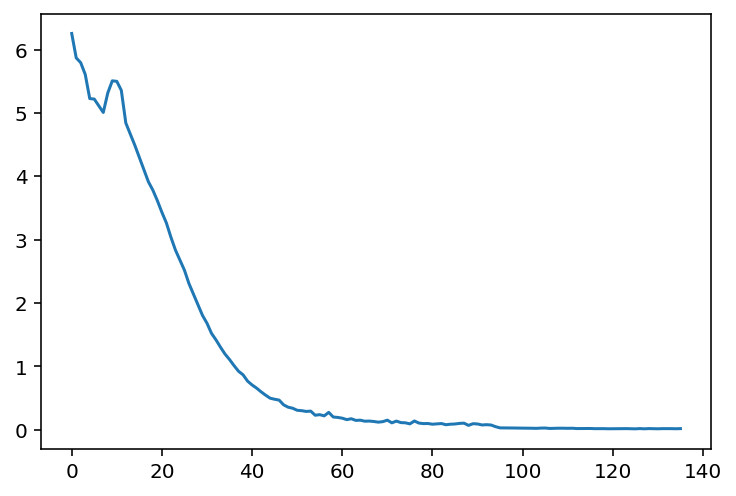

INFO:tensorflow:Assets written to: saved_model/CEO_LSTM_TIM_DEMO_V1/assets


INFO:tensorflow:Assets written to: saved_model/CEO_LSTM_TIM_DEMO_V1/assets


In [67]:
model_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/' + experiment_name + '/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', 
        factor=0.2,                 
        patience=5, 
        min_lr=1e-10,
        cooldown=3),
]

print("Training model\n")

history = model.fit(train_dataset, epochs=500, batch_size=64, callbacks=model_callbacks)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

model.save('saved_model/' + experiment_name)

In [68]:
model = tf.keras.models.load_model('saved_model/' + experiment_name)
model.evaluate(train_dataset)

62/62 [==============================] - 3s 23ms/step - loss: 0.0109 - duration_loss: 0.0051 - offset_loss: 9.6541e-06 - pitch_loss: 0.0058 - duration_accuracy: 0.9980 - offset_accuracy: 1.0000 - pitch_accuracy: 0.9977


[0.01094338484108448,
 0.00508694676682353,
 9.654145287640858e-06,
 0.005846783053129911,
 0.9979838728904724,
 1.0,
 0.9977318644523621]

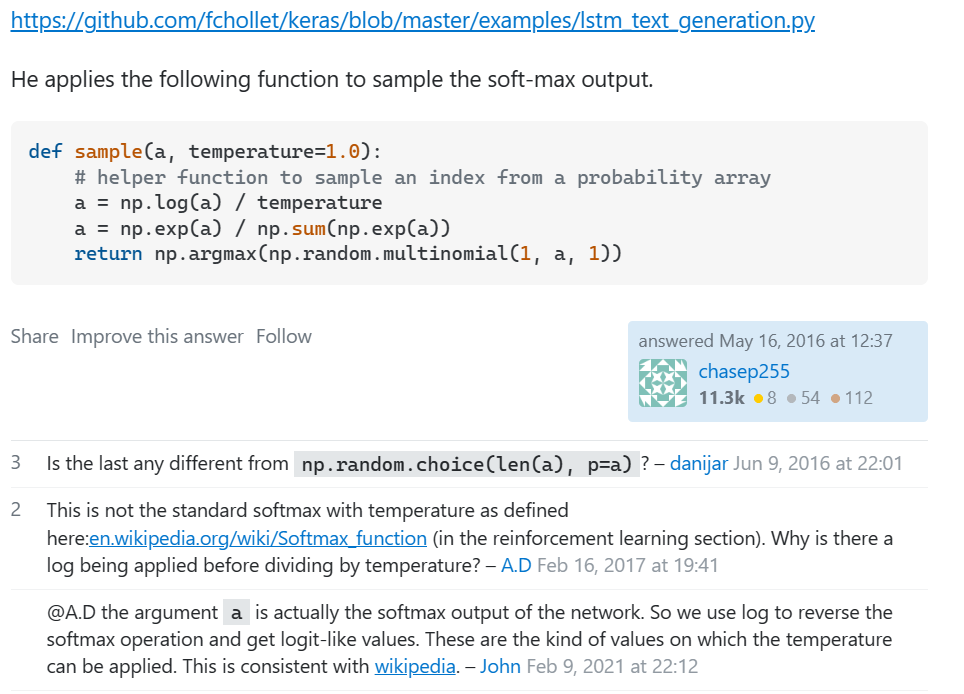

In [69]:
pitchTemperature = 1.0
durationTemperature = 1.0
offsetTemperature = 1.0
eventsToPredict = 500

# start from the beginning of the first song in the dataset
start = 0

index_to_note = dict((number, note) for number, note in enumerate(pitchnames))
index_to_duration = dict((number, duration) for number, duration in enumerate(durationnames))
index_to_offset = dict((number, offset) for number, offset in enumerate(offsetnames))

pattern = network_input[start]
prediction_output = collections.defaultdict(list)

# generate 500 notes
for note_index in range(eventsToPredict):
    prediction_input = np.expand_dims(pattern, axis = 0)

    prediction = model.predict(prediction_input, verbose=0)
            
    pitch_logits = prediction['pitch']
    duration_logits = prediction['duration']
    offset_logits = prediction['offset']
    
    pitch_predictions_with_temp = pitch_logits / pitchTemperature
    duration_predictions_with_temp = duration_logits / durationTemperature
    offset_predictions_with_temp = offset_logits / offsetTemperature
    
    #sample pitch
    pitch_selection = tf.random.categorical(pitch_predictions_with_temp, num_samples=1)
    
    #sample duration
    duration_selection = tf.random.categorical(duration_predictions_with_temp, num_samples=1)
    
    #sample offset
    offset_selection = tf.random.categorical(offset_predictions_with_temp, num_samples=1)
    
    pitch_index = int(np.squeeze(pitch_selection))
    duration_index = int(np.squeeze(duration_selection))
    offset_index = int(np.squeeze(offset_selection))
    
    predicted_pitch = index_to_note[pitch_index]
    predicted_duration = index_to_duration[duration_index]
    predicted_offset = index_to_offset[offset_index]
        
    print("Predicted pitch: " + predicted_pitch)
    print("Predicted duration: " + predicted_duration)
    print("Predicted offset: " + predicted_offset + "\n")
    
    #append actual pitches/durations to prediction_output
    prediction_output['pitch'].append(predicted_pitch)
    prediction_output['duration'].append(predicted_duration)
    prediction_output['offset'].append(predicted_offset)

    #need to append processed pitch to pattern
    pattern = np.append(pattern, [[pitch_index / float(n_vocab_pitch), duration_index / float(n_vocab_duration), offset_index / float(n_vocab_offset)]], 0)
    
    pattern = pattern[1:len(pattern)]
    
print(str(eventsToPredict) + " events predicted")

Predicted pitch: rest
Predicted duration: 3.0
Predicted offset: 0.0

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D2
Predicted duration: 1.5
Predicted offset: 0.25

Predicted pitch: F3
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E3
Predicted duration: 0.5
Predicted offset: 0.25

Predicted pitch: E2
Predicted duratio

Predicted pitch: rest
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: rest
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: A2
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: B3
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: 2~4
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E1
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D2
Predi

Predicted pitch: E1
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: D2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D2
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E3
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: D2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: D2
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.25

Predicted pitch: E2
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: E1
Predicted duration: 0.75
Predicted offset: 0.25

Predicted pitch: E1
Predicted duration: 3.5
Predicted offset: 0.0

Predicted pitch: E1
Predicted duration: 0.5
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 3.

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0

Predicted pitch: E1
Predicted duration: 0.5
Predicted offset: 0.1666666666666572

Predicted pitch: E1
Predicted duration: 0.5
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 5/12
Predicted offset: 0.08333333333334281

Predicted pitch: rest
Predicted duration: 5/12
Predicted offset: 0

Predicted pitch: E1
Predicted duration: 0.25
Predicted offset: 0.4166666666666572

Predicted pitch: E1
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 4.0
Predicted offset: 0.0

Predicted pitch: E1
Predicted duration: 0.75
Predicted offset: 0.25

Predicted pitch: E1
Predicted duration: 0.75
Predicted offset: 0.0

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.75

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0.25

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0.25

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0.0

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.08333333333334281

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 1/4

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 1/12

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 1/4

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.08333333333334281

Predicted pitch: 11
Predicted duration: 0.25
Predicted offset: 0.0

Predicted pitch: rest
Predicted duration: 1/12
Predicted offset: 0.25

Predict

In [71]:
""" convert the output from the prediction to notes and create a midi file
        from the notes """
output_notes = []
last_offset = 0

# create note and chord objects based on the values generated by the model
for i in range(len(prediction_output['pitch'])):
    
    pattern_pitch = prediction_output['pitch'][i]
    pattern_duration = float(Fraction(prediction_output['duration'][i]))
    pattern_offset = float(Fraction(prediction_output['offset'][i]))
    
    # pattern is a chord
    if ('~' in pattern_pitch) or pattern_pitch.isdigit():
        notes_in_chord = pattern_pitch.split('~')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note), quarterLength=pattern_duration)
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = last_offset + pattern_offset
        last_offset = last_offset + pattern_offset
        output_notes.append(new_chord)
    # pattern is a rest
    elif(pattern_pitch == 'rest'):
        new_note = note.Rest(quarterLength=pattern_duration)
        new_note.offset = last_offset + pattern_offset
        last_offset = last_offset + pattern_offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # pattern is a time signature
    elif('time' in pattern_pitch):
        new_note = meter.TimeSignature(pattern_pitch.split('-')[1])
        new_note.offset = last_offset + pattern_offset
        last_offset = last_offset + pattern_offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # pattern is a note
    else:
        new_note = note.Note(pattern_pitch, quarterLength=pattern_duration)
        new_note.offset = last_offset + pattern_offset
        last_offset = last_offset + pattern_offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        

output_stream = stream.Stream(output_notes)
    
output_stream.write('midi', fp=export_midi_path + '.mid')

'./generated_midi/CEO_LSTM_TIM_DEMO_V1.mid'